<a href="https://colab.research.google.com/github/yair-byte/YOLOv8_traffic_density_estimator/blob/main/YOLOv8x_traffic_density_estimator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Pip install method (recommended)

!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.83 🚀 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 23.3/78.2 GB disk)


In [3]:
!pip install supervision==0.2.0


from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.2.0


In [24]:
from supervision.draw.color import ColorPalette
from supervision import Point
from supervision import VideoInfo
from supervision import get_video_frames_generator
from supervision import VideoSink
from supervision import show_frame_in_notebook
from supervision import Detections, BoxAnnotator
from supervision.detection.line_counter import LineZone, LineZoneAnnotator
from supervision import draw_text
from supervision import Color

In [16]:
HOME = os.getcwd()
print(HOME)

/content


In [17]:
# Define la nueva clase común
vehicle_labels = ["car", "truck", "bus"]

In [18]:
%cd {HOME}

/content


In [19]:
SOURCE_VIDEO_PATH = f"{HOME}/video1.mp4"

In [20]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric

from IPython import display
display.clear_output()

import sys
sys.path.append(f"{HOME}/ByteTrack")

import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [21]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass

@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [22]:
# converts Detections into format that can be consumed by match_detections_with_tracks function

from typing import List

import numpy as np


def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections, 
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)
    
    tracker_ids = [None] * len(detections)
    
    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

In [23]:
from ultralytics import YOLO

model = YOLO("yolov8x.pt")
model.fuse()

100%|██████████| 131M/131M [00:06<00:00, 19.7MB/s]
YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


In [25]:
CLASS_NAMES_DICT = model.model.names

In [26]:
print(CLASS_NAMES_DICT)

{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microw

In [27]:
# class_ids of interest

# Obtener las claves para cada valor buscado
CLASS_ID = []
for valor in vehicle_labels:
    CLASS_ID += [clave for clave, valor_dic in CLASS_NAMES_DICT.items() if valor_dic == valor]

# Imprimir el resultado
print(CLASS_ID)


[2, 7, 5]



0: 384x640 14 cars, 79.5ms
Speed: 0.6ms preprocess, 79.5ms inference, 17.8ms postprocess per image at shape (1, 3, 640, 640)


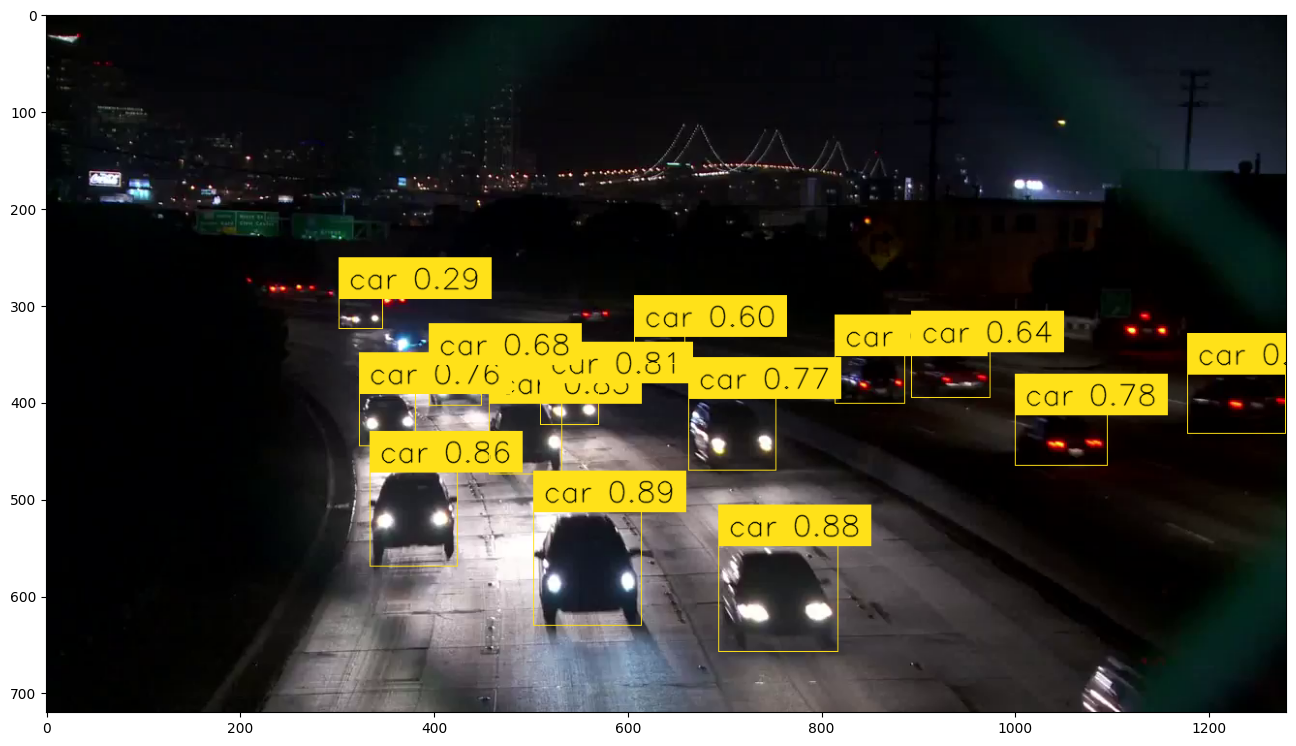

In [28]:
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(thickness=1, text_thickness=1, text_scale=1)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))

In [29]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1280, height=720, fps=30, total_frames=4795)

In [31]:
# settings
LINE_START = Point(200, 530)
LINE_END = Point(1280-1, 330)

TARGET_VIDEO_PATH = f"{HOME}/video1-result.mp4"

In [ ]:
from tqdm.notebook import tqdm

NUM_CARRILES = 4

DENSIDAD_NIVEL = ["MUY POCO TRAFICO","POCO TRAFICO","TRAFICO MEDIO","TRAFICO ALTO","TRAFICO MUY ALTO","TRAFICO EXCESIVO"]
DENSIDAD_NIVEL_COLOR = [Color(124,205,124),Color(0,124,0),Color(0,100,0),
                        Color(255,140,148),Color(255,70,0),Color(220,20,60)]

densidad_actual_str_derecha = ''
densidad_actual_str_izq = ''

cont_mano_derecha = 0
cont_mano_izq = 0

ventana_derecha = []
ventana_izq = []

pointer_derecha = np.zeros(2,dtype=int)
pointer_izq = np.zeros(2,dtype=int)

background_color_derecha = Color.black()
background_color_izq = Color.black()

# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

text_anchor_derecha = Point(x=int((video_info.width/2)+200), y=100)
text_anchor_izq = Point(x=300, y=100)

# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create LineCounter instance
line_counter = LineZone(start=LINE_START, end=LINE_END)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(thickness=1, text_thickness=1, text_scale=1)
line_annotator = LineZoneAnnotator(thickness=1, text_thickness=1, text_scale=1)
frame_id_cont=1

# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # filtering out detections with unwanted classes
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # tracking detections
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)
        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # format custom labels
        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]
        # updating line counter
        line_counter.trigger(detections=detections)
        # annotate and display frame
        frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)
        line_annotator.annotate(frame=frame, line_counter=line_counter)

        ventana_derecha.append(line_counter.in_count - cont_mano_derecha) 
        ventana_izq.append(line_counter.out_count - cont_mano_izq) 

        cont_mano_derecha = line_counter.in_count
        cont_mano_izq = line_counter.out_count

        #calc pointers for buffers
        pointer_derecha[1] = frame_id_cont
        pointer_izq[1] = frame_id_cont

        pointer_derecha[0] = (pointer_derecha[1] - (video_info.fps*60)) #por minuto
        if(pointer_derecha[0] <= 0):
          pointer_derecha[0] = 0
        
        pointer_izq[0] = (pointer_izq[1] - (video_info.fps*60)) 
        if(pointer_izq[0] <= 0):
          pointer_izq[0] = 0

        autos_por_unidad_tiempo_derecha = 0
        autos_por_unidad_tiempo_izq = 0

        for i in range(pointer_derecha[0], pointer_derecha[1]):
          autos_por_unidad_tiempo_derecha += ventana_derecha[i]

        for i in range(pointer_izq[0], pointer_izq[1]):
          autos_por_unidad_tiempo_izq += ventana_izq[i]

        autos_por_unidad_tiempo_derecha = autos_por_unidad_tiempo_derecha / NUM_CARRILES
        if autos_por_unidad_tiempo_derecha <= 8:
          densidad_actual_str_derecha = DENSIDAD_NIVEL[0]
          background_color_derecha = DENSIDAD_NIVEL_COLOR[0]
        elif autos_por_unidad_tiempo_derecha > 8 and autos_por_unidad_tiempo_derecha <= 16:
          densidad_actual_str_derecha = DENSIDAD_NIVEL[1]
          background_color_derecha = DENSIDAD_NIVEL_COLOR[1]
        elif autos_por_unidad_tiempo_derecha > 16 and autos_por_unidad_tiempo_derecha <= 24:
          densidad_actual_str_derecha = DENSIDAD_NIVEL[2]
          background_color_derecha = DENSIDAD_NIVEL_COLOR[2]
        elif autos_por_unidad_tiempo_derecha > 24 and autos_por_unidad_tiempo_derecha <= 32:
          densidad_actual_str_derecha = DENSIDAD_NIVEL[3]
          background_color_derecha = DENSIDAD_NIVEL_COLOR[3]
        elif autos_por_unidad_tiempo_derecha > 32 and autos_por_unidad_tiempo_derecha <= 40:
          densidad_actual_str_derecha = DENSIDAD_NIVEL[4]
          background_color_derecha = DENSIDAD_NIVEL_COLOR[4]
        else:
          densidad_actual_str_derecha = DENSIDAD_NIVEL[5]
          background_color_derecha = DENSIDAD_NIVEL_COLOR[5]

        autos_por_unidad_tiempo_izq = autos_por_unidad_tiempo_izq / NUM_CARRILES
        if autos_por_unidad_tiempo_izq <= 8:
          densidad_actual_str_izq = DENSIDAD_NIVEL[0]
          background_color_izq = DENSIDAD_NIVEL_COLOR[0]
        elif autos_por_unidad_tiempo_izq > 8 and autos_por_unidad_tiempo_izq <= 16:
          densidad_actual_str_izq = DENSIDAD_NIVEL[1]
          background_color_izq = DENSIDAD_NIVEL_COLOR[1]
        elif autos_por_unidad_tiempo_izq > 16 and autos_por_unidad_tiempo_izq <= 24:
          densidad_actual_str_izq = DENSIDAD_NIVEL[2]
          background_color_izq = DENSIDAD_NIVEL_COLOR[2]
        elif autos_por_unidad_tiempo_izq > 24 and autos_por_unidad_tiempo_izq <= 32:
          densidad_actual_str_izq = DENSIDAD_NIVEL[3]
          background_color_izq = DENSIDAD_NIVEL_COLOR[3]
        elif autos_por_unidad_tiempo_izq > 32 and autos_por_unidad_tiempo_izq <= 40:
          densidad_actual_str_izq = DENSIDAD_NIVEL[4]
          background_color_izq = DENSIDAD_NIVEL_COLOR[4]
        else:
          densidad_actual_str_izq = DENSIDAD_NIVEL[5]
          background_color_izq = DENSIDAD_NIVEL_COLOR[5]

        frame = draw_text(scene=frame, text=densidad_actual_str_derecha, text_anchor=text_anchor_derecha, text_scale=1, text_thickness=1, background_color=background_color_derecha)
        frame = draw_text(scene=frame, text=densidad_actual_str_izq, text_anchor=text_anchor_izq, text_scale=1, text_thickness=1, background_color=background_color_izq)
        sink.write_frame(frame)
        print(frame_id_cont)
        frame_id_cont=frame_id_cont+1